In [ ]:
# First, check PyTorch version
import torch
torch_version = torch.__version__

# Then install the appropriate PyTorch Geometric version
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch_version}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch_version}.html
!pip install torch-geometric
!pip install ipdb

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 57.6 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 64.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.6 MB/s eta 0:00:00


Processing...
Done!


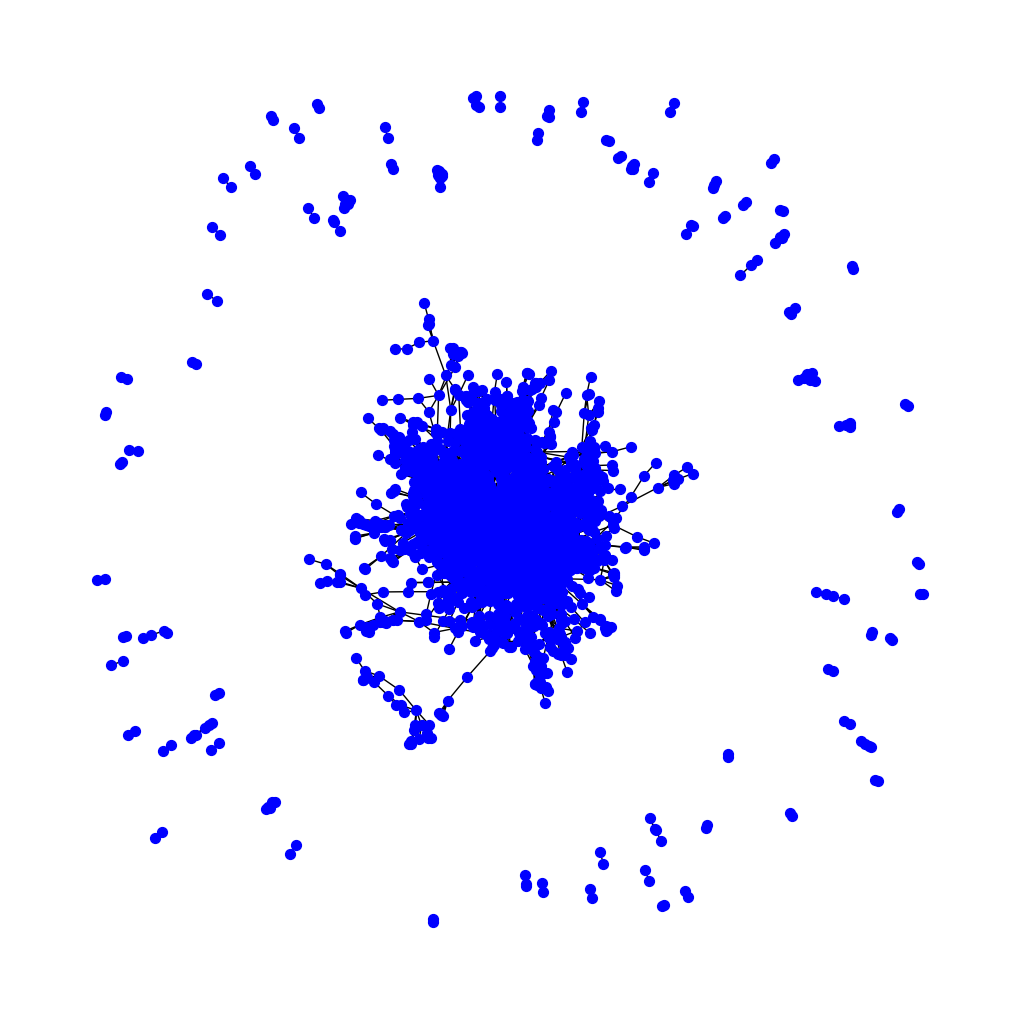

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import torch_geometric
from torch_geometric.datasets import Planetoid

graph = Planetoid(root='/tmp/CORA', name='CORA')[0]

G = to_networkx(graph, to_undirected=True)

# Plot a small subset of the graph
plt.figure(figsize=(10, 10))
nx.draw(G, node_size=50, node_color="blue", with_labels=False)
plt.show()


In [ ]:
# graph.y.unique()
mask1 = graph.edge_index[0] == 0
mask2 = graph.edge_index[1] == 0
mask2 | mask1
graph

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch.nn import Module
import torch
import ipdb # For debugging

class SimpleGNN(Module):
  def __init__(self, num_node_features, num_classes, num_edges):
    super(SimpleGNN, self).__init__()
    self.nodes_lin = Linear(num_node_features,100, dtype=torch.float32)
    self.output_lin = Linear(100, 7, dtype=torch.float32)

  def forward(self, data):
    edge_index = data.edge_index
    nodes = data.x
    nodes = self.nodes_lin(nodes)
    nodes = F.relu(nodes)
    pooled_nodes = []
    for i, node in enumerate(nodes):
      neighbors_mask = edge_index[0] == i
      neighbors = edge_index[1][neighbors_mask]
      feat_aggregation = torch.sum(nodes[torch.cat((neighbors, torch.tensor([i]).to('cuda')))], dim=0)
      pooled_nodes.append(feat_aggregation)
    pooled_nodes = torch.stack(pooled_nodes)
    output = self.output_lin(pooled_nodes)
    output = F.relu(output)
    output = F.softmax(output)

    return output


In [ ]:
import numpy.ma as ma
from torch.optim import Adam
from torch.nn import CrossEntropyLoss


NUM_EPOCHS = 100
LR = 0.001

graph = graph.to('cuda')

model = SimpleGNN(graph.x.shape[1], graph.x.shape[0], graph.edge_index.shape[1]).to('cuda')
optimizer = Adam(model.parameters(), LR)
criterion = CrossEntropyLoss()
target = graph.y

for i in range(NUM_EPOCHS):
  optimizer.zero_grad()
  output = model(graph)
  loss = criterion(output[graph.train_mask], target[graph.train_mask])
  loss.backward()
  optimizer.step()
  print(loss.item())





<ipython-input-4-f5a3398dea56>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(output)


1.9471280574798584
1.9343671798706055
1.9208347797393799
1.9061139822006226
1.8896342515945435
1.8714442253112793
1.8516511917114258
1.8301485776901245
1.8070214986801147
1.7825994491577148
1.7573193311691284
1.7314903736114502
1.7054777145385742
1.6794897317886353
1.6537961959838867
1.6286016702651978
1.6040184497833252
1.580125093460083
1.5570237636566162
1.5348395109176636
1.5137341022491455
1.4938701391220093
1.4753682613372803
1.4582842588424683
1.4425973892211914
1.428215742111206
1.4150257110595703
1.402917742729187
1.3918310403823853
1.3816756010055542
1.3723787069320679
1.3638794422149658
1.3561341762542725
1.3490625619888306
1.342607855796814
1.3367230892181396
1.3313851356506348
1.326537013053894
1.3221317529678345
1.3181220293045044
1.3144762516021729
1.3111613988876343
1.3081556558609009
1.3054314851760864
1.3029755353927612
1.3007664680480957
1.2987794876098633
1.2969863414764404
1.2953579425811768
1.2938902378082275
1.2925570011138916
1.2913395166397095
1.290237903594970

In [ ]:
m = graph.edge_index[0] == 0
n = graph.edge_index[1][m]
feat = torch.cat((n,torch.tensor([0])))
torch.sum(graph.x[feat], dim=1)

RuntimeError: ignored